# Spatially Varying Label Smoothing: Capturing Uncertainty from Expert Annotations
[Preprint](https://arxiv.org/pdf/2104.05788.pdf)
[Code](https://github.com/mobarakol/SVLS)

Downloading SVLS and Surface Dice codes

In [1]:
!rm -rf SVLS
!git clone https://github.com/mobarakol/SVLS.git
%cd SVLS
!git clone https://github.com/deepmind/surface-distance.git
!mv surface-distance surface_distance

Cloning into 'SVLS'...
remote: Enumerating objects: 388, done.
remote: Counting objects: 100% (388/388), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 388 (delta 345), reused 374 (delta 336), pack-reused 0
Receiving objects: 100% (388/388), 63.35 KiB | 1.76 MiB/s, done.
Resolving deltas: 100% (345/345), done.
/content/SVLS
Cloning into 'surface-distance'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 45 (delta 0), reused 2 (delta 0), pack-reused 40
Unpacking objects: 100% (45/45), done.


Install require packages:

In [2]:
!pip install -U -q SimpleITK

     |████████████████████████████████| 48.4 MB 1.7 MB/s 


### Download Dataset and Trained Models

In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Trained Models: https://drive.google.com/file/d/1evE2VqBGdY-0VPB8OeArHMPdRXhWuxFm/view?usp=sharing <br>
Validation Data: https://drive.google.com/file/d/1oZ9z-l9lBjKGNZCCTK819Z1ufwe90mg3/view?usp=sharing

In [5]:
ids = ['1evE2VqBGdY-0VPB8OeArHMPdRXhWuxFm', '1oZ9z-l9lBjKGNZCCTK819Z1ufwe90mg3']
zip_files = ['ckpt_brats19.zip','train_valid.zip']
for id, zip_file in zip(ids, zip_files):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(zip_file)
    !unzip -q $zip_file

Demo

valid sample: 66 valid minibatch: 33
model:best_oh.pth.tar , dice[ET:0.802 ± 0.179, TC:0.861 ± 0.128, WT:0.892 ± 0.074], ECE:0.0768, TACE:0.0041
model:best_oh.pth.tar , Surface dice[ET:0.916 ± 0.196, TC:0.862 ± 0.181, WT:0.894 ± 0.147]
model:best_ls0.1.pth.tar , dice[ET:0.825 ± 0.152, TC:0.873 ± 0.131, WT:0.892 ± 0.071], ECE:0.0659, TACE:0.0025
model:best_ls0.1.pth.tar , Surface dice[ET:0.933 ± 0.169, TC:0.888 ± 0.175, WT:0.911 ± 0.121]
model:best_ls0.2.pth.tar , dice[ET:0.819 ± 0.148, TC:0.861 ± 0.135, WT:0.892 ± 0.070], ECE:0.0931, TACE:0.0049
model:best_ls0.2.pth.tar , Surface dice[ET:0.929 ± 0.185, TC:0.879 ± 0.183, WT:0.906 ± 0.127]
model:best_ls0.3.pth.tar , dice[ET:0.788 ± 0.209, TC:0.858 ± 0.161, WT:0.891 ± 0.072], ECE:0.1467, TACE:0.0073
model:best_ls0.3.pth.tar , Surface dice[ET:0.914 ± 0.195, TC:0.873 ± 0.188, WT:0.919 ± 0.113]
model:best_svls.pth.tar , dice[ET:0.817 ± 0.138, TC:0.864 ± 0.118, WT:0.895 ± 0.064], ECE:0.0614, TACE:0.0040
model:best_svls.pth.tar , Surface dice[

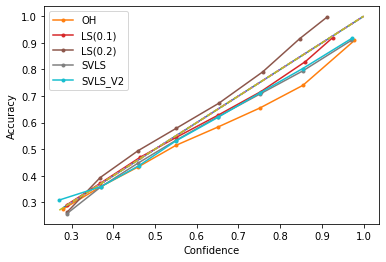

In [7]:
import argparse
import os
import numpy as np
import pathlib
import torch
from torch.nn import functional as F
from model import UNet3D
from datasets import get_datasets_brats
from utils import seed_everything, EDiceLoss
from calibration_metrics import ece_eval, tace_eval, reliability_diagram
import warnings
warnings.filterwarnings("ignore")
        
def step_valid(data_loader, model, metric):
    ece_all, acc_all, conf_all, tace_all = [], [], [], []
    losses, metrics, metrics_sd = [], [], []
    model.eval()
    for i, batch in enumerate(data_loader):
        targets = batch["label"].squeeze(1).cuda(non_blocking=True)
        inputs = batch["image"].float().cuda()
        segs = model(inputs)
        outputs = F.softmax(segs, dim=1).detach().cpu().numpy()
        if len(targets.shape) < 4:#if batch size=1
            targets = targets.unsqueeze(0)
        labels = targets.detach().cpu().numpy()
        
        ece, acc, conf, _ = ece_eval(outputs,labels)
        tace, _, _, _ = tace_eval(outputs,labels)
        ece_all.append(ece)
        acc_all.append(acc)
        conf_all.append(conf)
        tace_all.append(tace)
        segs = segs.data.max(1)[1].squeeze_(1)
        metric_ = metric.metric_brats(segs, targets)
        metrics_sd.extend(metric.get_surface_dice(segs.detach().cpu().numpy(), targets.detach().cpu().numpy()))
        metrics.extend(metric_)

    ece_avg = np.stack(ece_all).mean(0)
    acc_avg = np.stack(acc_all).mean(0)
    conf_avg = np.stack(conf_all).mean(0)
    tace_avg = np.stack(tace_all).mean(0)
    return metrics, metrics_sd, ece_avg, acc_avg, conf_avg, tace_avg
    
def main():
    parser = argparse.ArgumentParser(description='SVLS Brats Training')
    parser.add_argument('--batch_size', default=2, type=int,help='mini-batch size')
    parser.add_argument('--num_classes', default=4, type=int, help="num of classes")
    parser.add_argument('--in_channels', default=4, type=int, help="num of input channels")
    parser.add_argument('--train_option', default='SVLS', help="options:[SVLS, LS, OH]")
    parser.add_argument('--epochs', default=200, type=int, help='number of total epochs to run')
    parser.add_argument('--data_root', default='train_valid', help='data directory')
    parser.add_argument('--ckpt_dir', default='ckpt_brats19', help='ckpt directory')
    args = parser.parse_args(args=[]) 

    _, val_dataset = get_datasets_brats(data_root=args.data_root)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
        pin_memory=False, num_workers=2)

    print('valid sample:',len(val_dataset), 'valid minibatch:',len(val_loader))

    model = UNet3D(inplanes=args.in_channels, num_classes=args.num_classes).cuda()

    model = torch.nn.DataParallel(model)
    criterion_dice = EDiceLoss().cuda()
    
    legends = ['OH', 'LS(0.1)', 'LS(0.2)', 'LS(0.3)', 'SVLS', 'SVLS_V2']
    model_list = ['best_oh.pth.tar', 'best_ls0.1.pth.tar', 'best_ls0.2.pth.tar', 'best_ls0.3.pth.tar', 'best_svls.pth.tar', 'best_svls_v2.pth.tar']
    # legends = ['SVLS_V2']
    # model_list = ['best_svls_v2.pth.tar']
    for model_name, legend in zip(model_list, legends):
        state_dict = torch.load(os.path.join(args.ckpt_dir, model_name))
        if 'state_dict' in state_dict.keys():
          state_dict = state_dict['state_dict']
        model.load_state_dict(state_dict)
        model.eval()
        with torch.no_grad():
            dice_metrics, metrics_sd, ece_avg, acc_avg, conf_avg, tace_avg = step_valid(val_loader, model, criterion_dice)
        if legend != 'LS(0.3)':
            reliability_diagram(conf_avg, acc_avg, legend=legend)
        dice_metrics = list(zip(*dice_metrics))
        dice_metrics = [torch.tensor(dice, device="cpu").numpy() for dice in dice_metrics]
        avg_dices = np.mean(dice_metrics,1)
        avg_std = np.std(dice_metrics,1)

        metrics_sd = list(zip(*metrics_sd))
        metrics_sd = [torch.tensor(dice, device="cpu").numpy() for dice in metrics_sd]
        avg_sd = np.mean(metrics_sd,1)
        avg_std_sd = np.std(metrics_sd,1)

        print('model:%s , dice[ET:%.3f ± %.3f, TC:%.3f ± %.3f, WT:%.3f ± %.3f], ECE:%.4f, TACE:%.4f'%(
            model_name, avg_dices[0],avg_std[0], avg_dices[1],avg_std[1], avg_dices[2],avg_std[2], ece_avg, tace_avg))
        
        print('model:%s , Surface dice[ET:%.3f ± %.3f, TC:%.3f ± %.3f, WT:%.3f ± %.3f]'%(
            model_name, avg_sd[0],avg_std_sd[0], avg_sd[1],avg_std_sd[1], avg_sd[2],avg_std_sd[2]))

if __name__ == '__main__':
    seed_everything()
    main()
